#**Transfer Learning**


# Library Needed



In [ ]:
# Common Tools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import zipfile #Manejar archivos comprimidos en Colab
import os, pathlib, PIL

#Keras layers and image preprocessing
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input
#from keras.utils import to_categorical
#from keras.utils import plot_model

# Classification report and visualization
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import roc_curve, auc
from itertools import cycle
from sklearn.preprocessing import LabelBinarizer
import seaborn as sns

# Save and load best CNN models
from keras.callbacks import ModelCheckpoint
from keras.models import load_model

#Transfer Learning and MLP Layers
from keras.models import Sequential, Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.applications.xception import Xception
from keras.applications.inception_v3 import InceptionV3
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization, Input

#Data visualization (Bokeh)
from bokeh.io import output_notebook, show
output_notebook()
from bokeh.plotting import figure
from bokeh.models import NumeralTickFormatter
from bokeh.layouts import row
import random
import cv2

# Carga del dataset

Para este proceso, se empleo un dataset ubicado en Kaggle

Por ello se requiere a quien ejecute el modelo, tener una cuenta en kaggle y una autorización de API de modo que se obtenga el archivo ***kaggle.json***


In [ ]:
!pip install kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"sergiocantilloluna","key":"ab1c45e08473d8ebc6b64991828f6d6b"}'}

A través de comandos de servidor linux, se otorgan permisos para descarga y manipulación del dataset comprimido (.zip) proveniennte de Kaggle, luego de este proceso se procede a su descompresión

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d sauravagarwal/flower-classification
!ls # Revisión de archivos descargados

 99% 217M/219M [00:07<00:00, 27.6MB/s]
100% 219M/219M [00:07<00:00, 30.3MB/s]
flower-classification.zip  kaggle.json	sample_data


In [ ]:
zip_ref = zipfile.ZipFile('flower-classification.zip', 'r')
zip_ref.extractall('files') #Extracción de archivos descargados
zip_ref.close()

#Reconocimiento del Dataset

In [ ]:
train_dir = '/content/files/flowers/flowers/flower_photos/train'
valid_dir = '/content/files/flowers/flowers/flower_photos/validation'
test_dir = '/content/files/flowers/flowers/flower_photos/test'

In [ ]:
data_dir = pathlib.Path(train_dir)
folder = list(data_dir.glob('*'))
images = list(data_dir.glob('*/*.jpg')) #list of all images (full path)
print('Folder Structure:')
for f in folder:
    print(f)
print('\nNumber of images: ', len(images))

Folder Structure:
/content/files/flowers/flowers/flower_photos/train/sunflowers
/content/files/flowers/flowers/flower_photos/train/tulips
/content/files/flowers/flowers/flower_photos/train/daisy
/content/files/flowers/flowers/flower_photos/train/roses
/content/files/flowers/flowers/flower_photos/train/dandelion

Number of images:  3540


In [ ]:
data_dir = pathlib.Path(valid_dir)
folder = list(data_dir.glob('*'))
images = list(data_dir.glob('*/*.jpg')) #list of all images (full path)
print('Folder Structure:')
for f in folder:
    print(f)
print('\nNumber of images: ', len(images))

Folder Structure:
/content/files/flowers/flowers/flower_photos/validation/sunflowers
/content/files/flowers/flowers/flower_photos/validation/tulips
/content/files/flowers/flowers/flower_photos/validation/daisy
/content/files/flowers/flowers/flower_photos/validation/roses
/content/files/flowers/flowers/flower_photos/validation/dandelion

Number of images:  80


In [ ]:
data_dir = pathlib.Path(test_dir)
folder = list(data_dir.glob('*'))
images = list(data_dir.glob('*/*.jpg')) #list of all images (full path)
print('Folder Structure:')
for f in folder:
    print(f)
print('\nNumber of images: ', len(images))

Folder Structure:
/content/files/flowers/flowers/flower_photos/test/sunflowers
/content/files/flowers/flowers/flower_photos/test/tulips
/content/files/flowers/flowers/flower_photos/test/daisy
/content/files/flowers/flowers/flower_photos/test/roses
/content/files/flowers/flowers/flower_photos/test/dandelion

Number of images:  50


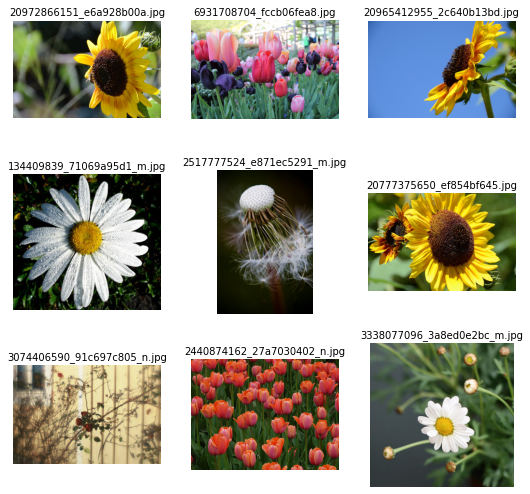

In [ ]:
fig = plt.figure(figsize=(9, 9))
for i in range(9):
  pic = random.randint(1,len(images)-1)
  plt.subplot(3, 3, i + 1)
  plt.title(str(images[pic]).split('/')[-1], fontsize=10) #get the file name and disply as title
  plt.imshow(PIL.Image.open(images[pic]))
  ax = plt.axis("off")

# Data Augmentation y Preprocesamiento


In [ ]:
IMAGE_SIZE = [256, 256]
BATCH_SIZE = 32  
NUM_EPOCHS = 20
CLASSES = ['daisy','dandelion','roses','sunflowers','tulips'] 
NUM_CLASSES = 5 

In [ ]:

datagen = ImageDataGenerator(
    rescale=1./255,  
    rotation_range=10,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=False, 
    #preprocessing_function=preprocess_input
    preprocessing_function=None)

train_gen = datagen.flow_from_directory(
        directory=train_dir,  
        target_size=IMAGE_SIZE,
        color_mode='rgb',
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        classes = CLASSES,
        seed = 42,
        shuffle = False) 

valid_gen = datagen.flow_from_directory(
        directory=valid_dir,  
        target_size=IMAGE_SIZE,  
        color_mode='rgb',
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        classes = CLASSES,
        seed = 42,
        shuffle = False)

test_gen = datagen.flow_from_directory(
        directory=test_dir,  
        target_size=IMAGE_SIZE,  
        color_mode='rgb',
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        classes = CLASSES,
        seed = 42,
        shuffle = False)

Found 3540 images belonging to 5 classes.
Found 80 images belonging to 5 classes.
Found 50 images belonging to 5 classes.


In [ ]:
test_datagen = ImageDataGenerator(rescale=1./255)
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=False,
    validation_split = 0.2)

train_gen = train_datagen.flow_from_directory(
        directory="/content/files/flowers/flowers/flower_photos/train",  
        target_size=(224, 224),
        color_mode='rgb',
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        subset = 'training',
        classes = CLASSES,
        seed = 42,
        shuffle = False) 

valid_gen = train_datagen.flow_from_directory(
        directory="/content/files/flowers/flowers/flower_photos/validation",  
        target_size=(224, 224),  
        color_mode='rgb',
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        subset = 'validation',
        classes = CLASSES,
        seed = 42,
        shuffle = False)

test_gen = test_datagen.flow_from_directory(
        directory="/content/files/flowers/flowers/flower_photos/test",  
        target_size=(224, 224),  
        color_mode='rgb',
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        classes = CLASSES,
        seed = 42,
        shuffle = False)

Found 2834 images belonging to 5 classes.
Found 15 images belonging to 5 classes.
Found 25 images belonging to 5 classes.


## Visualización de Datos


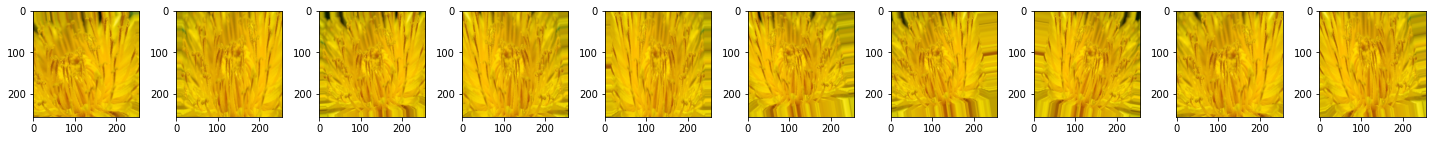

(256, 256, 3)


In [ ]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        Image = np.clip(img, 0, 1)
        ax.imshow(Image)
    plt.tight_layout()
    plt.show()
    print(Image.shape)

augmented_images = [train_gen[20][0][1] for i in range(10)]
plotImages(augmented_images)

# Transfer Learning: Solo empleando capas de Feature Extraction


Se utilizan las capas de extracción de características de un modelo ya entrenado conocido como VGG16, en el cual se adicionó y entrenó una única capa adaptable a este set de datos, la cual de tipo *dense* con una función de activación softmax para la selección de las clases. 

Como parametros de ajuste de la red, se utilizó el optimizador nadam y la función de perdida por entropía cruzada, dadas las caracteristicas del set de imágenes.

In [ ]:
tlm = VGG16(input_shape = IMAGE_SIZE + [3], weights='imagenet', include_top=False)
for layer in tlm.layers:
    layer.trainable = False

x = Flatten()(tlm.output)
prediction = Dense(NUM_CLASSES, activation='softmax')(x) 

model = Model(inputs=tlm.input, outputs=prediction)
model.summary()   

## Compilando el modelo

In [ ]:
model.compile(
  loss='categorical_crossentropy',
  optimizer='nadam',
  metrics=['accuracy']
)

## Entrenando (Ajustando) el modelo

A través del comando *ModelCheckpoint*, Se ajustará y guardará el mejor modelo de entrenamiento entregado por Keras para utilizar el set de test y comprobar el performance respectivo. 

In [ ]:
checkpointer = ModelCheckpoint(filepath='model.weights.best.hdf5', verbose = 1, save_best_only=True)
H = model.fit(
    train_gen,
    validation_data=valid_gen,
    epochs=NUM_EPOCHS,
    steps_per_epoch=len(train_gen),
    validation_steps=len(valid_gen),
    callbacks=[checkpointer])

## Rendimiento de la red al entrenar

In [ ]:
# create a new plot with default tools, using figure
p1 = figure(plot_width=500, plot_height=300)
p1.line(range(NUM_EPOCHS),H.history['accuracy'], line_width=2,line_color='red',legend_label="Train Accuracy")
p1.line(range(NUM_EPOCHS),H.history['val_accuracy'], line_width=2, legend_label="Test Accuracy",line_dash=[6, 6])
p1.circle(range(NUM_EPOCHS),H.history['accuracy'], fill_color="white", size=4)
p1.circle(range(NUM_EPOCHS),H.history['val_accuracy'], fill_color="white", size=4)
p1.xaxis.axis_label = "N° of Epochs"
p1.yaxis.formatter = NumeralTickFormatter(format="0.0%")
p1.yaxis.axis_label = "Accuracy"
p1.legend.location = "bottom_right"
p2 = figure(plot_width=500, plot_height=300)
p2.line(range(NUM_EPOCHS),H.history['loss'], line_width=2,line_color='red',legend_label="Train Accuracy")
p2.line(range(NUM_EPOCHS),H.history['val_loss'], line_width=2, legend_label="Test Accuracy", line_dash=[6, 6])
p2.circle(range(NUM_EPOCHS),H.history['loss'], fill_color="white", size=4)
p2.circle(range(NUM_EPOCHS),H.history['val_loss'], fill_color="white", size=4)
p2.xaxis.axis_label = "N° of Epochs"
p2.yaxis.axis_label = "Loss"
show(row(p2,p1))

## Evaluando el modelo

### Con el dataset de prueba completo (test dataset)

Se evalúa el mejor modelo obtenido en el proceso de entrenamiento por medio de datos nuevos (correspondientes al set completo de test), para comprobar la generalización de la red, asi como la extracción de características provenientes del modelo pre-entrenado.

In [ ]:
modelFE = load_model('model.weights.best.hdf5')
test_eval = modelFE.evaluate(test_gen)
print('Test loss:', test_eval[0])
print('Test accuracy:', test_eval[1])

2/2 [==============================] - 6s 5s/step - loss: 1.2110 - accuracy: 0.7400
Test loss: 1.2110235691070557
Test accuracy: 0.7400000095367432


In [ ]:
predicted_classes = modelFE.predict(test_gen)
predicted_classes = np.argmax(predicted_classes,axis=1)
print(predicted_classes)

[0 0 0 0 0 0 0 0 0 0 1 1 1 1 3 1 1 1 4 1 2 2 4 4 1 2 4 2 0 4 3 4 3 2 3 3 4
 3 3 3 4 0 4 4 4 4 4 4 2 4]


In [ ]:
true_labels = test_gen.classes
print(true_labels)

[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3
 3 3 3 4 4 4 4 4 4 4 4 4 4]


# Transfer Learning: Aplicando Fine Tuning

Se realiza transfer Learning aplicando Fine tuning, agregándole al modelo pre-entrenado VGG16, desde el bloque 5 pool (ultima capa de feature classification) aplicando después de la capa flatten, dos capas densas con 128 neuronas con funciones de activación tipo ReLU y una capa densa de salida con una función de activación softmax para la clasificación. 

Para el entrenamiento de la red, se congelan todas las capas de la red, excepto las 3 ultimas capas (es decir las creadas), empleando una función de perdidda de entropia cruzada y optimizador adam (robusto y de rapida convergencia). 

In [ ]:
image_input = Input(shape=(256, 256, 3))
tlm2 = VGG16(input_tensor=image_input, weights='imagenet', include_top=False)

last_layer = tlm2.get_layer('block5_pool').output
x= Flatten(name='flatten')(last_layer)
x = Dense(128, activation='relu', name='fc1')(x)
x = Dense(128, activation='relu', name='fc2')(x)
out = Dense(NUM_CLASSES, activation='softmax', name='output')(x)
custom_model = Model(image_input, out)
for layer in custom_model.layers[:-3]:
	layer.trainable = False

custom_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0   

## Compilando el modelo

In [ ]:
custom_model.compile(loss='categorical_crossentropy',
                     optimizer='nadam',
                     metrics=['accuracy'])

## Entrenando (Ajustando) el modelo

Como en el caso anterior, A través del comando *ModelCheckpoint*, Se ajustará y guardará el mejor modelo de entrenamiento entregado por Keras para utilizar el set de test y comprobar el performance respectivo. 

In [ ]:
checkpointer2 = ModelCheckpoint(filepath='model2.weights.best.hdf5', verbose = 1, save_best_only=True)
H2 = custom_model.fit(
    train_gen,
    validation_data=valid_gen,
    epochs=NUM_EPOCHS,
    steps_per_epoch=len(train_gen),
    validation_steps=len(valid_gen),
    callbacks=[checkpointer2],)

Epoch 1/20
111/111 [==============================] - 55s 483ms/step - loss: 2.7318 - accuracy: 0.2396 - val_loss: 1.1274 - val_accuracy: 0.5625

Epoch 00001: val_loss improved from inf to 1.12736, saving model to model2.weights.best.hdf5
Epoch 2/20
111/111 [==============================] - 53s 478ms/step - loss: 1.0458 - accuracy: 0.6059 - val_loss: 0.9247 - val_accuracy: 0.6125

Epoch 00002: val_loss improved from 1.12736 to 0.92466, saving model to model2.weights.best.hdf5
Epoch 3/20
111/111 [==============================] - 53s 478ms/step - loss: 0.8071 - accuracy: 0.7009 - val_loss: 0.6713 - val_accuracy: 0.7875

Epoch 00003: val_loss improved from 0.92466 to 0.67127, saving model to model2.weights.best.hdf5
Epoch 4/20
111/111 [==============================] - 53s 480ms/step - loss: 0.7171 - accuracy: 0.7230 - val_loss: 0.8869 - val_accuracy: 0.7125

Epoch 00004: val_loss did not improve from 0.67127
Epoch 5/20
111/111 [==============================] - 53s 480ms/step - loss: 0

## Rendimiento de la red al entrenar

Como en el caso anterior, Se grafican los resultados obtenidos el en el entrenamiento y validación del modelo, a diferencia del otro caso se puede apreciar en este caso que apartir de la epoch 1 la exactitud supera el 95% con los 2 conjuntos, y desde la epoch 3 este indicador incrementa al 100%, por ende la función de perdida tambien presenta su valor mínimo. 
Esto evidencia un buen rendimiento de esta estructura al entrenar

In [ ]:
# create a new plot with default tools, using figure
p1 = figure(plot_width=500, plot_height=300)
p1.line(range(NUM_EPOCHS),H2.history['accuracy'], line_width=2,line_color='red',legend_label="Train Accuracy")
p1.line(range(NUM_EPOCHS),H2.history['val_accuracy'], line_width=2, legend_label="Test Accuracy",line_dash=[6, 6])
p1.circle(range(NUM_EPOCHS),H2.history['accuracy'], fill_color="white", size=4)
p1.circle(range(NUM_EPOCHS),H2.history['val_accuracy'], fill_color="white", size=4)
p1.xaxis.axis_label = "N° of Epochs"
p1.yaxis.formatter = NumeralTickFormatter(format="0.0%")
p1.yaxis.axis_label = "Accuracy"
p1.legend.location = "bottom_right"
p2 = figure(plot_width=500, plot_height=300)
p2.line(range(NUM_EPOCHS),H2.history['loss'], line_width=2,line_color='red',legend_label="Train Accuracy")
p2.line(range(NUM_EPOCHS),H2.history['val_loss'], line_width=2, legend_label="Test Accuracy", line_dash=[6, 6])
p2.circle(range(NUM_EPOCHS),H2.history['loss'], fill_color="white", size=4)
p2.circle(range(NUM_EPOCHS),H2.history['val_loss'], fill_color="white", size=4)
p2.xaxis.axis_label = "N° of Epochs"
p2.yaxis.axis_label = "Loss"
show(row(p2,p1))

## Evaluando el modelo

Se evalúa el mejor modelo obtenido en el proceso de entrenamiento por medio de datos nuevos (correspondientes al set completo de test), para comprobar la generalización de la red, asi como la extracción de características provenientes del modelo pre-entrenado.

### Con el dataset de prueba completo (test dataset)

In [ ]:
modelFT = load_model('model2.weights.best.hdf5')
test_evalFT = modelFT.evaluate(test_gen)
print('Test loss:', test_evalFT[0])
print('Test accuracy:', test_evalFT[1])

2/2 [==============================] - 1s 240ms/step - loss: 0.9916 - accuracy: 0.7400
Test loss: 0.991558313369751
Test accuracy: 0.7400000095367432


In [ ]:
predicted_classesFT = modelFT.predict(test_gen)
predicted_classesFT = np.argmax(predicted_classesFT,axis=1)
print(predicted_classesFT)

[2 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 4 1 2 2 4 4 0 2 4 2 4 4 3 4 3 2 3 0 0
 3 3 3 4 0 4 4 4 4 4 4 2 4]


In [ ]:
true_labelsFT = test_gen.classes
print(true_labelsFT[:])

[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3
 3 3 3 4 4 4 4 4 4 4 4 4 4]


# Evaluación de Rendimiento

Se realizó un análisis comparativo entre ambas aproximaciones de transfer learning empleando herramientas de visualización de métricas como:
* Classification Report
* Matriz de Confusión
* ROC-AUC Curve


## Classification Report



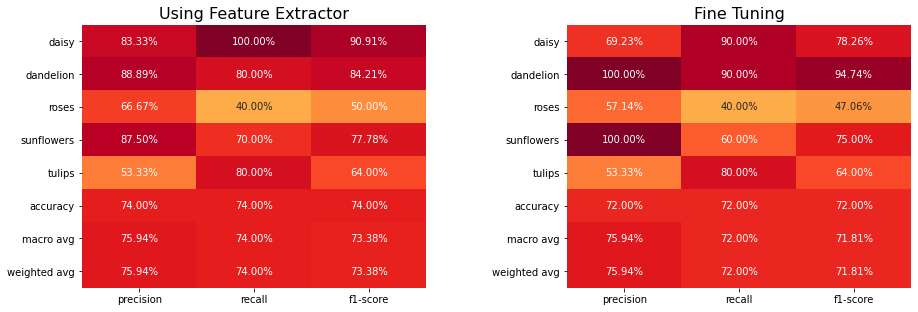

In [ ]:
Clases = train_gen.class_indices
fig, ax = plt.subplots(figsize=(15,7),ncols=2,nrows=1)
fig.tight_layout(pad=11.0)
clf_report1 = classification_report(true_labels, predicted_classes, digits = 4, target_names=[*Clases], output_dict=True)
clf_report2 = classification_report(true_labelsFT, predicted_classesFT, digits = 4, target_names=[*Clases], output_dict=True)
sns.heatmap(pd.DataFrame(clf_report1).iloc[:-1, :].T, annot=True,ax=ax[0], cbar=False, cmap='YlOrRd',fmt=".2%", cbar_kws={"ticks":[0,.1,.2,.3,.4,.5,.6,.7,.8,.9,1]},
            vmin = 0, vmax=1)
ax[0].set_title('Using Feature Extractor',fontsize = 16)
sns.heatmap(pd.DataFrame(clf_report2).iloc[:-1, :].T, annot=True,ax=ax[1], cbar=False, cmap='YlOrRd', fmt=".2%", cbar_kws={"ticks":[0,.1,.2,.3,.4,.5,.6,.7,.8,.9,1]},
            vmin = 0, vmax=1)
ax[1].set_title('Fine Tuning',fontsize = 16)
plt.show()

## Matriz de Confusión 

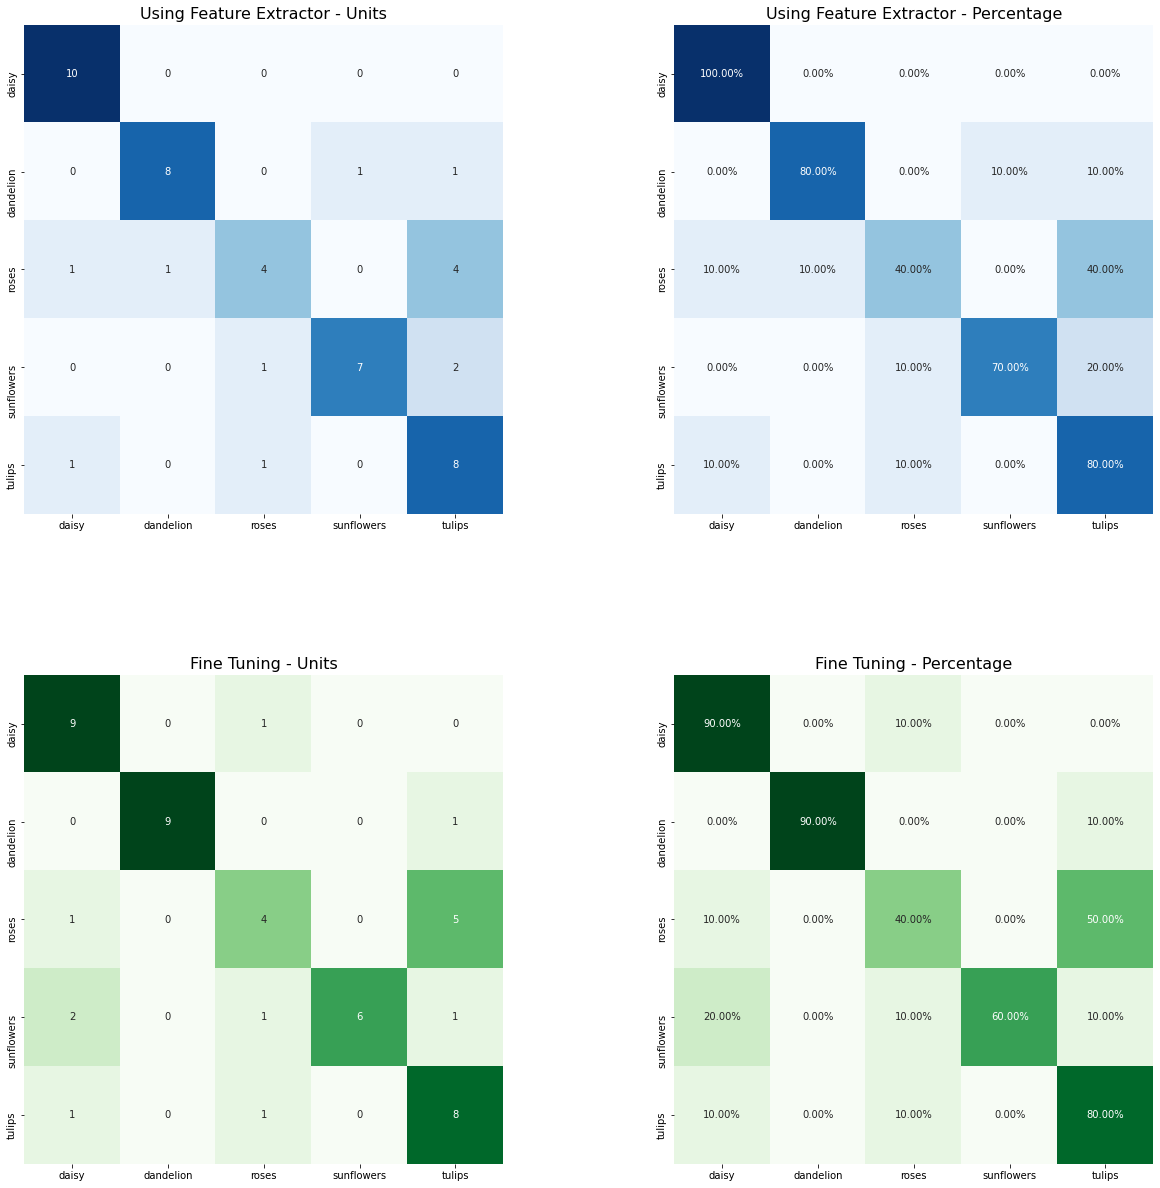

In [ ]:
fig, ax = plt.subplots(figsize=(20,20),ncols=2,nrows=2)
fig.tight_layout(pad=14.0)
ax[0][0].set_title('Using Feature Extractor - Units',fontsize = 16)
ax[0][1].set_title('Using Feature Extractor - Percentage',fontsize = 16)
ax[1][0].set_title('Fine Tuning - Units',fontsize = 16)
ax[1][1].set_title('Fine Tuning - Percentage',fontsize = 16)
sns.heatmap(confusion_matrix(true_labels, predicted_classes), fmt="d", annot=True, ax=ax[0][0], 
            cmap=plt.cm.Blues, xticklabels=[*Clases], yticklabels=[*Clases], cbar=False)
sns.heatmap(confusion_matrix(true_labels, predicted_classes, normalize='true'), fmt=".2%", annot=True, ax=ax[0][1],
            cmap=plt.cm.Blues, xticklabels=[*Clases], yticklabels=[*Clases], cbar=False)
sns.heatmap(confusion_matrix(true_labelsFT, predicted_classesFT), fmt="d", annot=True, ax=ax[1][0], 
            cmap=plt.cm.Greens, xticklabels=[*Clases], yticklabels=[*Clases], cbar=False)
sns.heatmap(confusion_matrix(true_labelsFT, predicted_classesFT, normalize='true'), fmt=".2%", annot=True, ax=ax[1][1],
            cmap=plt.cm.Greens, xticklabels=[*Clases], yticklabels=[*Clases], cbar=False)
plt.show()

## Curva ROC-AUC


In [ ]:
def plot_roc_curve(true_labels,predicted_classes,NUM_CLASSES, mode,**kwargs):
  plt.rcParams["figure.figsize"] = (6,4)
  fpr = dict()
  tpr = dict()
  lw=2
  roc_auc = dict()
  lb = LabelBinarizer()
  lb.fit(true_labels)
  true_labelsB = lb.transform(true_labels)
  predicted_classesB = lb.transform(predicted_classes)

  for i in range(NUM_CLASSES):
      fpr[i], tpr[i], _ = roc_curve(true_labelsB[i], predicted_classesB[i])
      roc_auc[i] = auc(fpr[i], tpr[i])

  # Compute micro-average ROC curve and ROC area
  fpr["micro"], tpr["micro"], _ = roc_curve(true_labelsB[i].ravel(), predicted_classesB[i].ravel())
  roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

  # Compute macro-average ROC curve and ROC area

  # First aggregate all false positive rates
  all_fpr = np.unique(np.concatenate([fpr[i] for i in range(NUM_CLASSES)]))

  # Then interpolate all ROC curves at this points
  mean_tpr = np.zeros_like(all_fpr)
  for i in range(NUM_CLASSES):
      mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

  # Finally average it and compute AUC
  mean_tpr /= NUM_CLASSES

  fpr["macro"] = all_fpr
  tpr["macro"] = mean_tpr
  roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

  # Plot all ROC curves
  plt.plot(fpr["micro"], tpr["micro"],
          label='micro-average ROC curve (area = {0:0.2f})'
                ''.format(roc_auc["micro"]),
          color='deeppink', linestyle=':', linewidth=4)

  plt.plot(fpr["macro"], tpr["macro"],
          label='macro-average ROC curve (area = {0:0.2f})'
                ''.format(roc_auc["macro"]),
          color='navy', linestyle=':', linewidth=4)

  colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
  for i, color in zip(range(NUM_CLASSES), colors):
      plt.plot(fpr[i], tpr[i], color=color, lw=lw,
              label='ROC curve of class {0} (area = {1:0.2f})'
              ''.format(CLASSES[i], roc_auc[i]))
  plt.plot([0, 1], [0, 1], 'k--', lw=lw)
  plt.xlim([-0.01, 1.0])
  plt.ylim([0.0, 1.01])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  title = 'Multi-class ROC Curve: '+mode
  plt.title(title)
  plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
  plt.show()

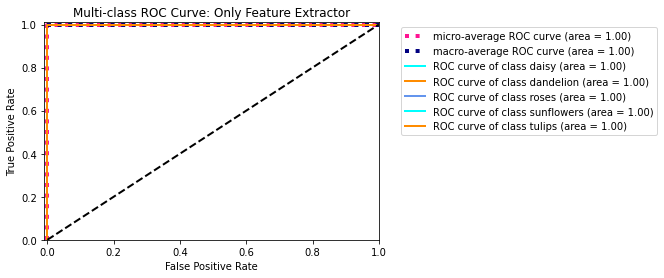

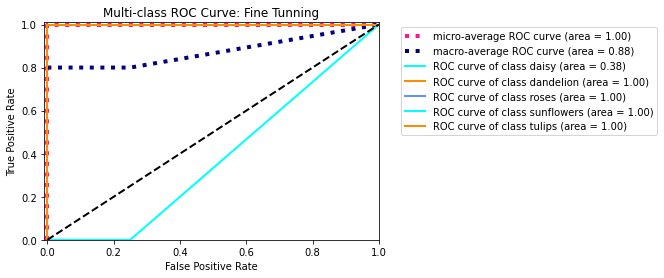

In [ ]:
plot_roc_curve(true_labels,predicted_classes,NUM_CLASSES,'Only Feature Extractor')
plot_roc_curve(true_labelsFT,predicted_classesFT,NUM_CLASSES, 'Fine Tunning')